In [1]:
library("lme4")
library("ggplot2")
library("dplyr")
library(MASS)
library("BayesFactor")
library("car")
library("scales")
library("lmerTest")
library("MuMIn")
library("plyr")
library("knitr")
library("MASS")
library("corrplot")
library("RColorBrewer")
library("rstatix")
library("ggpubr")
library("rgr")
library("lattice")
library("correlation")
library("boot")

Loading required package: Matrix


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: coda

************
Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************

Loading required package: carData

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

   

In [17]:
## Gives count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

In [18]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

In [19]:
#Load the data => Here, we are filtering the cases in which subjects had a MuIFI of 0
FinalPath<-'../ToInput/R_HumMod_MS17_1tracker.txt'
data <- read.delim(FinalPath, sep="\t", header=T, stringsAsFactors=F)
data <- data %>% filter(!Amplitude==0) %>% filter(!NewTracker=='no')
dataTest <- data
data$lCV <- log(data$CV)
data$GameSpeed <- factor(data$GameSpeed, levels = c("SSS","SMS","MSM","MMM"))
#NArow <- which(is.na(data$lCV))
#data <- data %>% filter(!is.na(lCV))

In [20]:
table(data$NewTracker, data$GameSpeed)

       
         SSS  SMS  MSM  MMM
  Human  273  282  286  273
  yes   1496 1498 1491 1499

In [21]:
Agent<-data$Agent
Subject <-data$Subject
GameSpeed <- data$GameSpeed
GameNb <- data$GameNb
Points <- data$Points
Perf_Means <- data.frame(Agent,Subject,GameSpeed,GameNb,Points)
#head(Perf_Means)

In [22]:
#Getting means for games 11-15
Perf11_15 <- Perf_Means
n_games <- 15
for(i in 1:5){
    Perf11_15 <- Perf11_15 %>% filter(GameNb!=i)
}
for(i in 6:10){
    Perf11_15 <- Perf11_15 %>% filter(GameNb!=i)
}
table(Perf11_15$Agent, Perf11_15$GameSpeed)

       
        SSS SMS MSM MMM
  Human  96  97  97  98
  Model 500 500 500 500

In [23]:
PerfMean11_15 <- ddply(Perf11_15, c("Agent","Subject","GameSpeed"), summarize,  Points=mean(Points))
PerfM11_15 <- PerfMean11_15[order(PerfMean11_15$Subject),]
nrow(PerfM11_15)
#head(PerfM11_15,10)

[1] 480

In [24]:
#Getting table for measures
MeasuresData <- data %>% filter(!Amplitude==0)
Agent<-MeasuresData$Agent
Subject <-MeasuresData$Subject
GameSpeed <- MeasuresData$GameSpeed
GameNb <- MeasuresData$GameNb
Regularity <- MeasuresData$Amplitude
Periodicity <- MeasuresData$Periodicity
lCV <- MeasuresData$lCV
Entropy <- MeasuresData$Entropy
Measures_Means <- data.frame(Agent,Subject,GameSpeed,GameNb,Entropy,lCV,Periodicity,Regularity)
#head(Measures_Means)

In [25]:
table(Measures_Means$Agent, Measures_Means$GameSpeed)

       
         SSS  SMS  MSM  MMM
  Human  273  282  286  273
  Model 1496 1498 1491 1499

In [26]:
#Getting means for games 11-15
Mea11_15 <- Measures_Means
n_games <- 15
for(i in 1:5){
    Mea11_15 <- Mea11_15 %>% filter(GameNb!=i)
}
for(i in 6:10){
    Mea11_15 <- Mea11_15 %>% filter(GameNb!=i)
}
table(Mea11_15$Agent, Mea11_15$GameSpeed)

       
        SSS SMS MSM MMM
  Human  96  97  97  98
  Model 500 500 500 500

In [27]:
All_11_15 <- ddply(Mea11_15, c("Agent","Subject","GameSpeed"), summarize,  Regularity=mean(Regularity), Periodicity=mean(Periodicity), Entropy=mean(Entropy),lCV=mean(lCV))
All_M11_15 <- All_11_15[order(All_11_15$Subject),]
All_M11_15$Points <- PerfM11_15$Points
nrow(All_M11_15)
head(All_M11_15,10)

[1] 480

,Agent,Subject,GameSpeed,Regularity,Periodicity,Entropy,lCV,Points
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Human,A10GBO6PU2EI0K,MSM,0.1727203,720.0,3.076229,-0.97389762,448.0
2,Human,A12WDL4PB927P6,SMS,0.1705716,1260.8,3.429772,-0.95585470,1644.0
3,Human,A12ZO39VZ879ZS,SMS,0.3551483,1203.2,3.230255,-1.41777493,1476.0
4,Human,A15J42M6EC7Y1K,SSS,0.1482720,1196.8,3.774199,-1.28699527,2148.0
5,Human,A16335MOISDG1F,MSM,0.3335070,614.4,2.951696,-1.59444789,3112.8
6,Human,A19M1TGTL9HKHB,SSS,0.1256377,1561.6,3.538243,-1.32914674,2025.6
7,Human,A1AJ2G7JXXJ8UJ,MMM,0.1756713,688.0,2.923656,-1.50812672,3143.2
8,Human,A1E8ZYOQSGKTP8,MSM,0.3671380,1004.8,3.297162,0.02207809,1111.2
9,Human,A1EQAFAN71Z0SK,SSS,0.3090110,1232.0,3.236643,-1.40030867,2137.2


# Linear Mixed Model

In [28]:
Human_Last5 <- All_M11_15 %>% filter(Agent=='Human')
Model_Last5 <- All_M11_15 %>% filter(Agent=='Model')
nrow(Human_Last5)

[1] 80

In [29]:
me_hf.fit = lmer(Points^2 ~ Entropy+Regularity+Periodicity+lCV+(1+Periodicity|GameSpeed), data=Human_Last5)
summary(me_hf.fit)

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
boundary (singular) fit: see ?isSingular

Warning message:
“Some predictor variables are on very different scales: consider rescaling”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: 9.4e-11”


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
Points^2 ~ Entropy + Regularity + Periodicity + lCV + (1 + Periodicity |  
    GameSpeed)
   Data: Human_Last5

REML criterion at convergence: 2398.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2875 -0.5053  0.0852  0.6107  1.9385 

Random effects:
 Groups    Name        Variance  Std.Dev. Corr 
 GameSpeed (Intercept) 3.077e+13 5547001       
           Periodicity 3.839e+07    6196  -1.00
 Residual              2.991e+12 1729320       
Number of obs: 80, groups:  GameSpeed, 4

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  2.455e+07  4.916e+06  3.866e+01   4.995 1.30e-05 ***
Entropy     -6.510e+06  1.276e+06  2.444e+03  -5.102 3.63e-07 ***
Regularity   2.792e+06  2.174e+06  1.872e+05   1.285  0.19897    
Periodicity -2.743e+03  3.284e+03  5.242e+00  -0.835  0.44006    
lCV         -1.606e+06  5.723e+05  5.642e+02  -2.806  0.

In [30]:
fixef(me_hf.fit)

(Intercept)      Entropy   Regularity  Periodicity          lCV 
24552689.809 -6510301.118  2791891.177    -2742.545 -1606117.185

In [31]:
me_hf.r <- r.squaredGLMM(me_hf.fit)
me_hf.r

Warning message:
“'r.squaredGLMM' now calculates a revised statistic. See the help page.”


R2m,R2c
0.551355,0.7967359


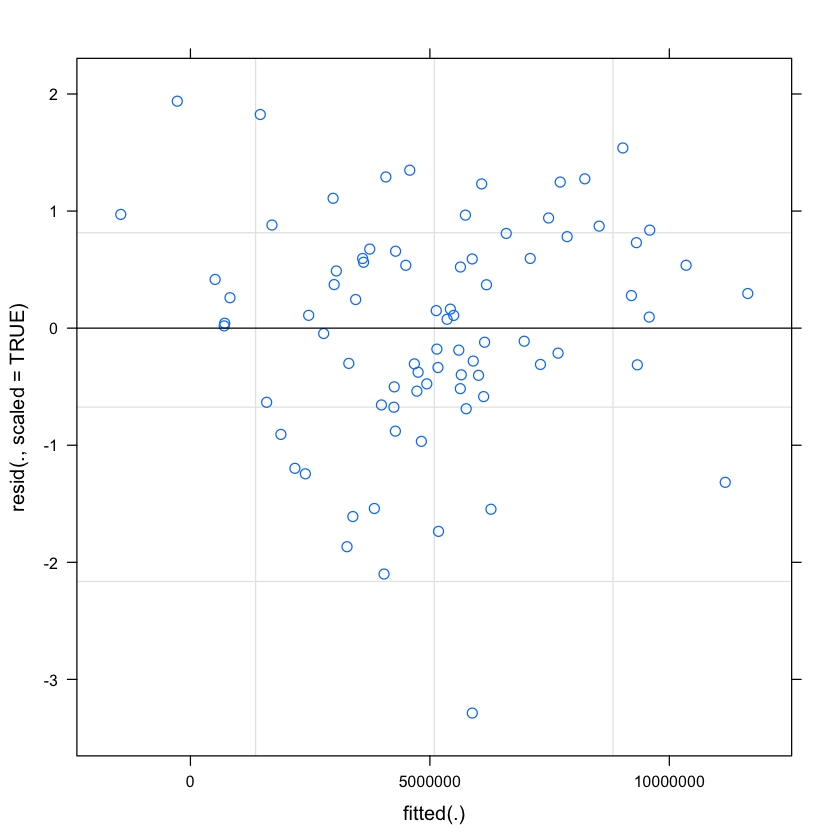

In [32]:
plot(me_hf.fit, resid(., scaled=TRUE) ~ fitted(.), abline = 0)

[1] 80

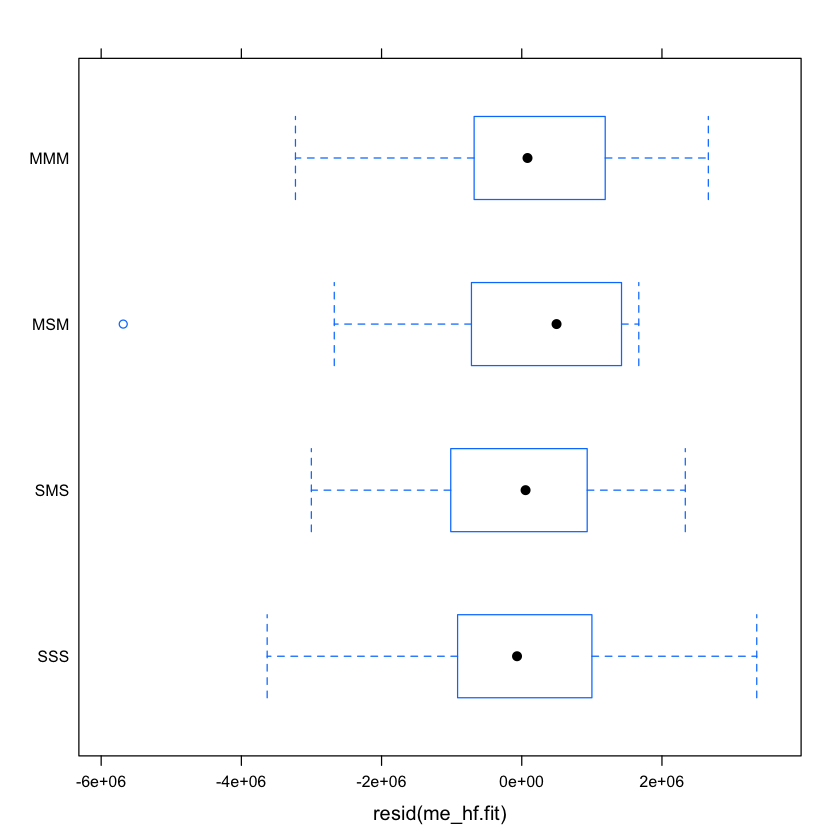


	Shapiro-Wilk normality test

data:  residual
W = 0.9755, p-value = 0.1273



	One-sample Kolmogorov-Smirnov test

data:  residual
D = 0.07055, p-value = 0.7943
alternative hypothesis: two-sided


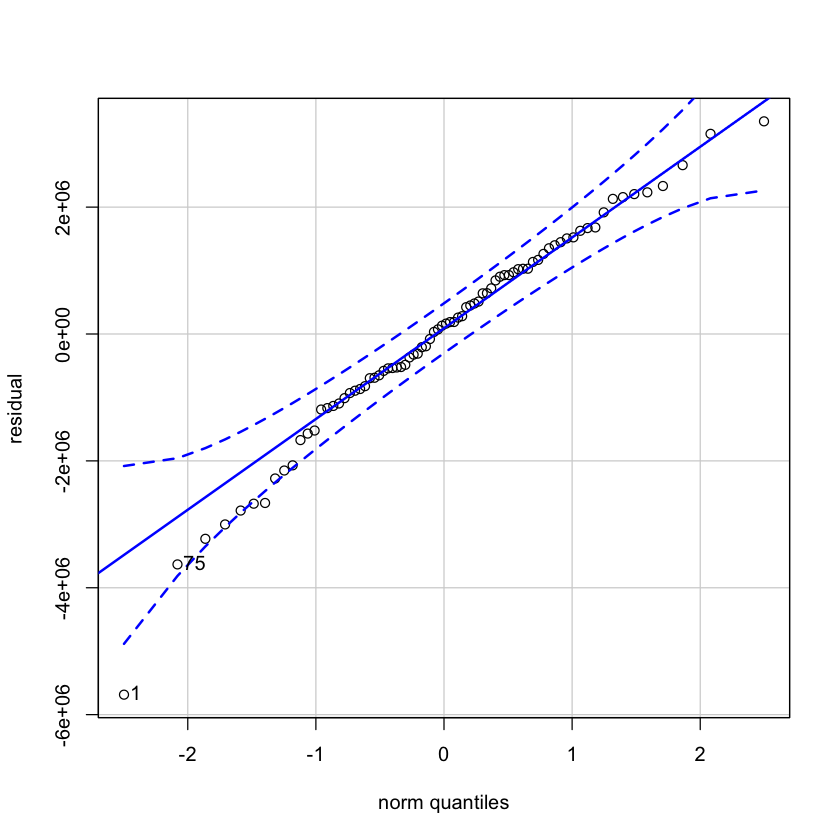

In [33]:
residual<-residuals(me_hf.fit)
length(residual)
pres1<-bwplot(GameSpeed~resid(me_hf.fit), Human_Last5)
pres1
pres2 <- qqPlot(residual)
#pres2
shapiro.test(residual)
ks.test(residual, "pnorm", mean=mean(residual), sd=sd(residual))
#pres2 <- plot(me_hf.fit)

In [34]:
bigBoot <- bootMer(me_hf.fit,fixef, nsim = 1000)
predCL <- t(apply(bigBoot$t, MARGIN = 2, FUN = quantile, probs = c(0.025, 0.975)))
#Margin means the function apply will be applied to columns
mf.lci <- predCL[,1]
mf.uci <- predCL[,2]
mf.lci
mf.uci

(Intercept)      Entropy   Regularity  Periodicity          lCV 
13673351.587 -9116802.423 -1250712.716    -9267.421 -2782394.689

(Intercept)      Entropy   Regularity  Periodicity          lCV 
35087741.203 -3890925.909  7154948.049     4301.051  -455440.592

In [35]:
boot.ci(bigBoot, index = 2, type = "perc")
boot.ci(bigBoot, index = 3, type = "perc")
boot.ci(bigBoot, index = 4, type = "perc")
boot.ci(bigBoot, index = 5, type = "perc")

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bigBoot, type = "perc", index = 2)

Intervals : 
Level     Percentile     
95%   (-9183614, -3858102 )  
Calculations and Intervals on Original Scale

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bigBoot, type = "perc", index = 3)

Intervals : 
Level     Percentile     
95%   (-1342736,  7185104 )  
Calculations and Intervals on Original Scale

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bigBoot, type = "perc", index = 4)

Intervals : 
Level     Percentile     
95%   (-9299,  4359 )  
Calculations and Intervals on Original Scale

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bigBoot, type = "perc", index = 5)

Intervals : 
Level     Percentile     
95%   (-2809412,  -452194 )  
Calculations and Intervals on Original Scale

# Multi-level correlations

In [36]:
Points <- Human_Last5$Points
Entropy <- Human_Last5$Entropy
GameSpeed <- Human_Last5$GameSpeed
ToCorrelate <- data.frame(Points,Entropy,GameSpeed)
#head(ToCorrelate,10)
correlation(ToCorrelate, multilevel = TRUE)

,Parameter1,Parameter2,r,CI_low,CI_high,t,df,p,Method,n_Obs
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,Points,Entropy,-0.6312282,-0.7473008,-0.4777746,-7.141601,78,4.230815e-10,Pearson,80


In [37]:
Points <- Human_Last5$Points
lCV <- Human_Last5$lCV
GameSpeed <- Human_Last5$GameSpeed
ToCorrelate <- data.frame(Points,lCV,GameSpeed)
correlation(ToCorrelate, multilevel = TRUE)

,Parameter1,Parameter2,r,CI_low,CI_high,t,df,p,Method,n_Obs
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,Points,lCV,-0.6225897,-0.7409495,-0.4667165,-6.981296,78,8.550178e-10,Pearson,80


In [38]:
Points <- Human_Last5$Points
Periodicity <- Human_Last5$Periodicity
GameSpeed <- Human_Last5$GameSpeed
ToCorrelate <- data.frame(Points,Periodicity,GameSpeed)
correlation(ToCorrelate, multilevel = TRUE)

,Parameter1,Parameter2,r,CI_low,CI_high,t,df,p,Method,n_Obs
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,Points,Periodicity,-0.2237937,-0.4227247,-0.004287591,-2.014886,78,0.04736257,Pearson,80


In [39]:
Points <- Human_Last5$Points
Regularity <- Human_Last5$Regularity
GameSpeed <- Human_Last5$GameSpeed
ToCorrelate <- data.frame(Points,Regularity,GameSpeed)
correlation(ToCorrelate, multilevel = TRUE)

,Parameter1,Parameter2,r,CI_low,CI_high,t,df,p,Method,n_Obs
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,Points,Regularity,0.3778357,0.1724338,0.5517482,3.580941,78,0.0005932254,Pearson,80


# Plot correlations with performance

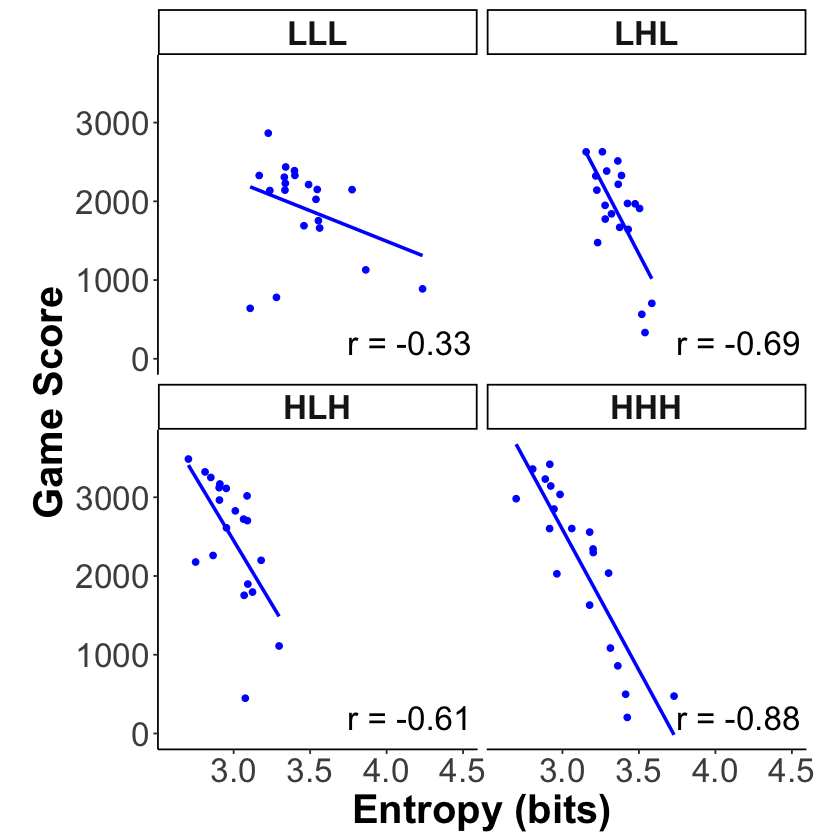

In [40]:
p1 <- ggplot(Human_Last5, aes(Entropy, Points)) + geom_point(color="blue") + geom_smooth(method='lm', se=FALSE, color="blue", formula= y~x)
#abline(lm(Human_Last5$Points~Human_Last5$Entropy), col="black")
NewLabs <- c(MMM="HHH",MSM="HLH",SMS="LHL",SSS="LLL")

# Calculate correlation for each group
cors <- ddply(Human_Last5, c("GameSpeed"), summarise, cor = format(round(cor(Entropy, Points), 2)), nsmall = 2)

p1 <- p1 + theme_classic() +
geom_text(data=cors, aes(label=paste("r = ", format(cor, nsmall = 2), sep="")), x=4.15, y=200, size=7) +
     labs(x = "Entropy (bits)", y = "Game Score") +
     theme(plot.title = element_text(size=18,hjust=0.5),
           axis.text = element_text(size = 20),
           strip.text = element_text(size = 20,face = "bold"),
           axis.title = element_text( size = 24, face = "bold" ),
           plot.background = element_blank(),
           panel.background = element_blank(),
           aspect.ratio = 1) +
    scale_x_continuous(limits=c(2.6,4.5))
p1<- p1+ facet_wrap(~ GameSpeed, labeller = labeller(GameSpeed = NewLabs), nrow = 2)
p1

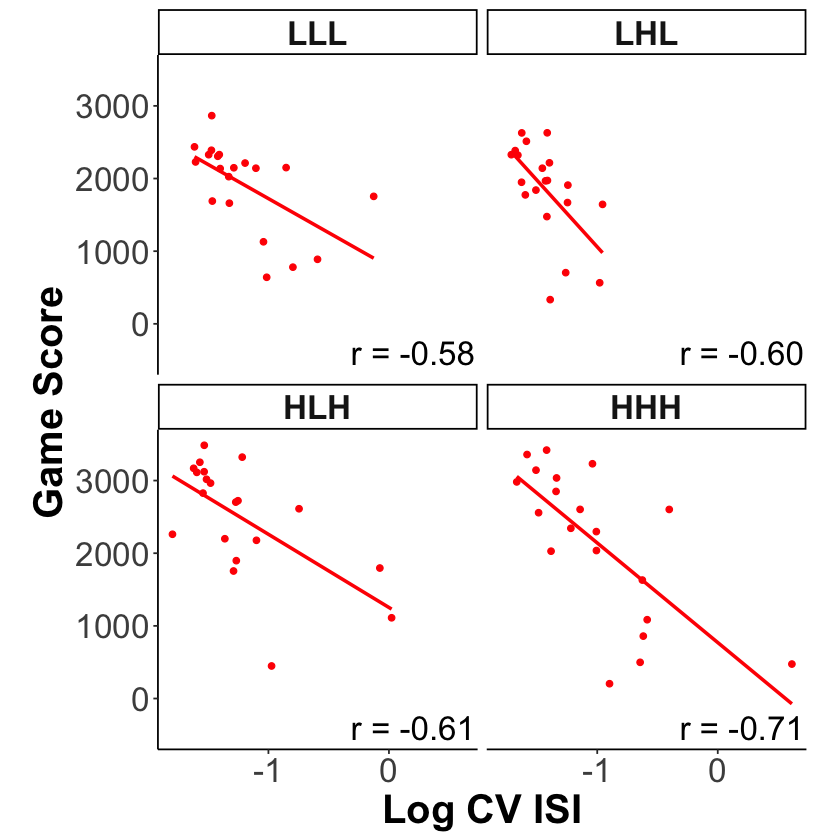

In [41]:
p2 <- ggplot(Human_Last5, aes(lCV, Points)) + geom_point(color="red") + geom_smooth(method='lm', se=FALSE, color="red", formula= y~x)

# Calculate correlation for each group
cors2 <- ddply(Human_Last5, c("GameSpeed"), summarise, cor = round(cor(lCV, Points), 2))

p2 <- p2 + theme_classic() +
geom_text(data=cors2, aes(label=paste("r = ", format(cor, nsmall = 2), sep="")), x=0.2, y=-400, size=7) +
     labs(x = "Log CV ISI", y = "Game Score") + 
     theme(plot.title = element_text(size=18,hjust=0.5),
           axis.text = element_text(size = 20),
           strip.text = element_text(size = 20,face = "bold"),
           axis.title = element_text( size = 24, face = "bold" ),
           plot.background = element_blank(),
           panel.background = element_blank(),
           aspect.ratio = 1) +
     scale_y_continuous(limits=c(-500,3500))
p2<-p2 + facet_wrap(~ GameSpeed, labeller = labeller(GameSpeed = NewLabs), nrow = 2)
p2

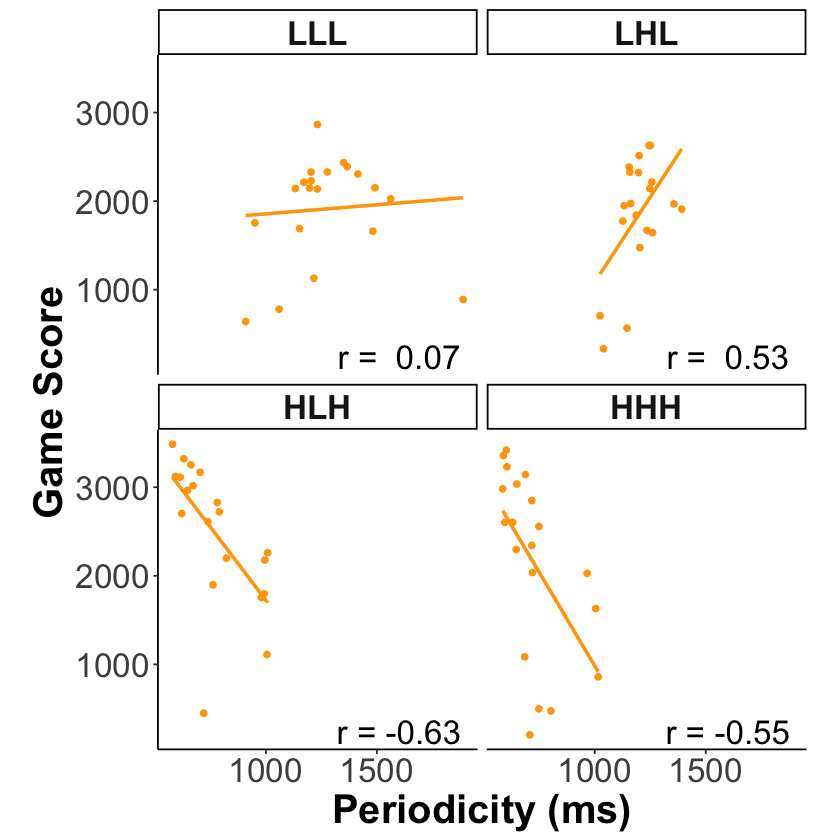

In [42]:
p3 <- ggplot(Human_Last5, aes(Periodicity, Points)) + geom_point(color="orange") + geom_smooth(method='lm', se=FALSE, color="orange", formula= y~x)

# Calculate correlation for each group
cors <- ddply(Human_Last5, c("GameSpeed"), summarise, cor = round(cor(Periodicity, Points), 2))

p3 <- p3 + theme_classic() +
geom_text(data=cors, aes(label=paste("r = ", format(cor, nsmall = 2), sep="")), x=1600, y=240, size=7) +
     labs(x = "Periodicity (ms)", y = "Game Score") + 
     theme(plot.title = element_text(size=18,hjust=0.5),
           axis.text = element_text(size = 20),
           strip.text = element_text(size = 20,face = "bold"),
           axis.title = element_text( size = 24, face = "bold" ),
           plot.background = element_blank(),
           panel.background = element_blank(),
           aspect.ratio = 1) 
p3 <- p3 + facet_wrap(~ GameSpeed, labeller = labeller(GameSpeed = NewLabs), nrow = 2)
p3

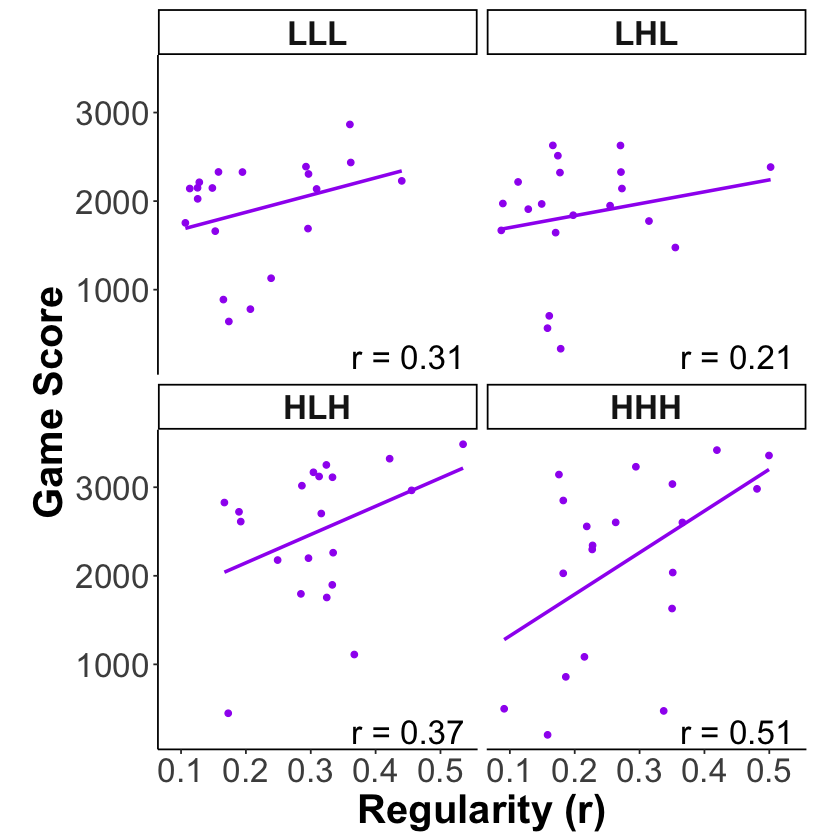

In [43]:
p4 <- ggplot(Human_Last5, aes(Regularity, Points)) + geom_point(color="purple") + geom_smooth(method='lm', se=FALSE, color="purple", formula= y~x)

# Calculate correlation for each group
cors <- ddply(Human_Last5, c("GameSpeed"), summarise, cor = round(cor(Regularity, Points), 2))

p4 <- p4 + theme_classic() +
geom_text(data=cors, aes(label=paste("r = ", format(cor, nsmall = 2), sep="")), x=0.45, y=240, size=7) +
     labs(x = "Regularity (r)", y = "Game Score") + 
     theme(plot.title = element_text(size=18,hjust=0.5),
           axis.text = element_text(size = 20),
           strip.text = element_text(size = 20,face = "bold"),
           axis.title = element_text( size = 24, face = "bold" ),
           plot.background = element_blank(),
           panel.background = element_blank(),
           aspect.ratio = 1) 
p4 <- p4 + facet_wrap(~ GameSpeed, labeller = labeller(GameSpeed = NewLabs), nrow = 2)
p4

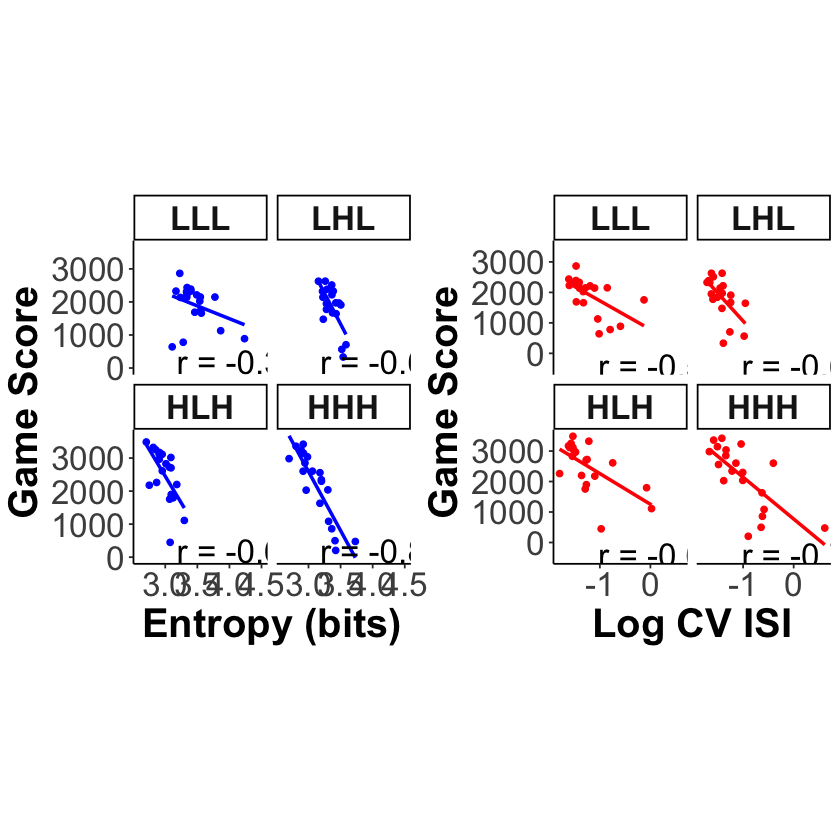

In [44]:
#Saving measures boxplots
multiplot(p1,p2, cols=2)
ggsave("../Figures/Correlations1.png",multiplot(p1,p2, cols=2),width=19,height=9)

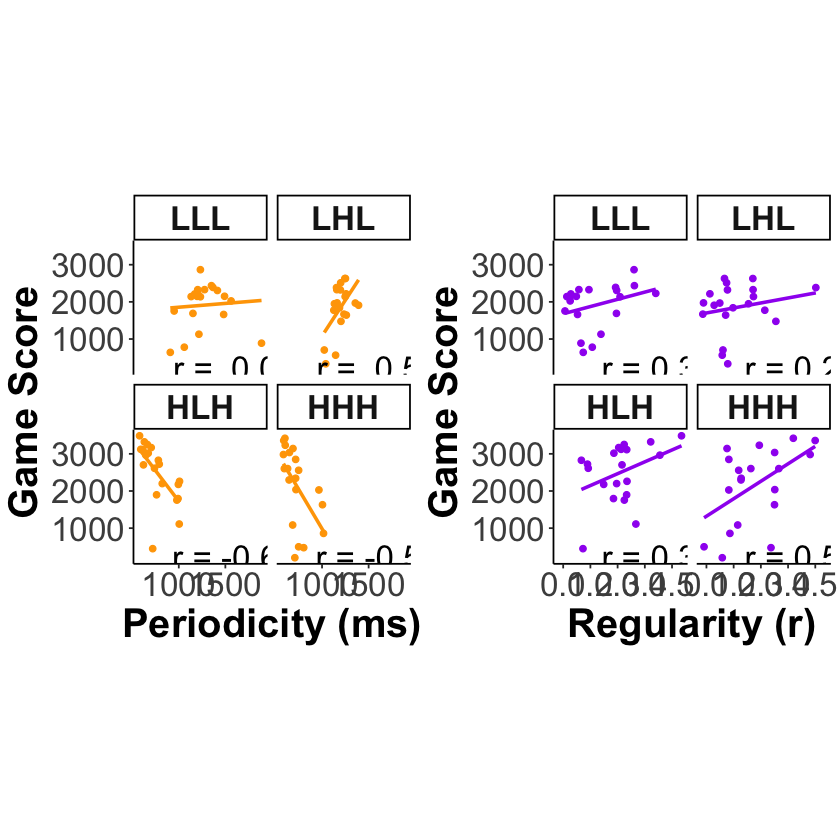

In [45]:
#Saving measures boxplots
multiplot(p3,p4, cols=2)
ggsave("../Figures/Correlations2.png",multiplot(p3,p4, cols=2),width=19,height=9)